# Level 1 - Subpopulation Discovery

In [1]:
from src.bladder_proteomics.utils import load_data, validate_data
df = load_data("../data/proteomics.txt", transpose=True, index_col=0, sep="\t")# transpose because shape (proteins, patients) -> PCA/UMAP expects (patients, proteins)
# metadata = load_data("../data/metadata.csv", index_col=0)

In [2]:
# validate_data(df)
# validate_data(metadata, expected_features=13)

In [3]:
from src.bladder_proteomics.preprocessing import log1p_transform, zscore_normalize, variance_filter

# Preprocess
df = log1p_transform(df)
df = zscore_normalize(df, axis=0)
df, mask = variance_filter(df, percentile=10)

In [4]:
from src.bladder_proteomics.dimensionality_reduction import apply_pca, apply_umap

# DIMENSIONALITY REDUCTION
pca_df, pca_model = apply_pca(df, n_components=12, return_model=True) # return explained variance from PCA
for i, variance in enumerate(pca_model.explained_variance_ratio_):
    print(f"PC{i+1:<2} explains {variance*100:>5.2f}% of variance")
total_variance = sum(pca_model.explained_variance_ratio_)
print(f"In total, the first {len(pca_model.explained_variance_ratio_)} PCs explain {total_variance*100:.2f}% of variance")

umap_df = apply_umap(df, n_components=2)

PC1  explains 31.11% of variance
PC2  explains 14.61% of variance
PC3  explains  6.91% of variance
PC4  explains  5.83% of variance
PC5  explains  4.85% of variance
PC6  explains  3.66% of variance
PC7  explains  3.24% of variance
PC8  explains  2.69% of variance
PC9  explains  2.43% of variance
PC10 explains  2.28% of variance
PC11 explains  1.97% of variance
PC12 explains  1.63% of variance
In total, the first 12 PCs explain 81.23% of variance


/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


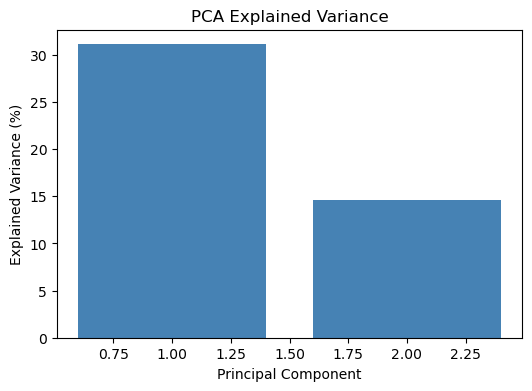

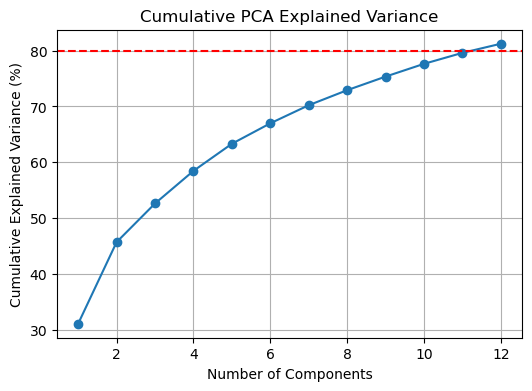

In [5]:
from src.bladder_proteomics.plotting.visualizers import (
    plot_pca_variance,
    plot_pca_cumulative_variance,
)
plot_pca_variance(pca_model, max_components=2)
plot_pca_cumulative_variance(pca_model, threshold=0.80)

PCA was applied to the log-transformed, z-score normalized proteomics data to estimate the major axes of variation among patients.
- PC1 explains 31% of the total variance and represents the strongest source of biological or technical variation.
- PC2 explains 14.6%, and the first two PCs together account for 45.7% of the variability in the dataset.
- The cumulative explained variance analysis shows that approximately 12 components are required to capture 80% of the total variance.

In [6]:
# Silhouette and elbow methods can be used to choose optimal K
from src.bladder_proteomics.k_selection import silhouette_analysis, elbow_method, calculate_elbow_point

scores = silhouette_analysis(df, k_range=range(2, 11))
print(scores)
best_k = max(scores, key=scores.get)
print("Best k (silhouette):", best_k)

{2: 0.7530411653503268, 3: 0.654776920615817, 4: 0.6574953330911733, 5: 0.6591772706751521, 6: 0.6536959511510226, 7: 0.643330874661712, 8: 0.6355698962844682, 9: 0.5859060760531947, 10: 0.32468826083962904}
Best k (silhouette): 2


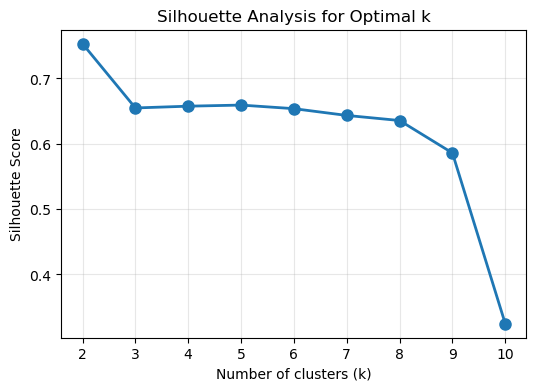

In [7]:
from src.bladder_proteomics.plotting import plot_silhouette_scores
plot_silhouette_scores(scores)

- k=2 is the best, by far.
- From k=3 to k=8, the scores are all ~0.64–0.66 -> they are acceptable, but not great.
- At k >= 9, the score collapses -> clusters become meaningless.

**Silhouette conclusion:**
The dataset naturally forms 2 very stable clusters.

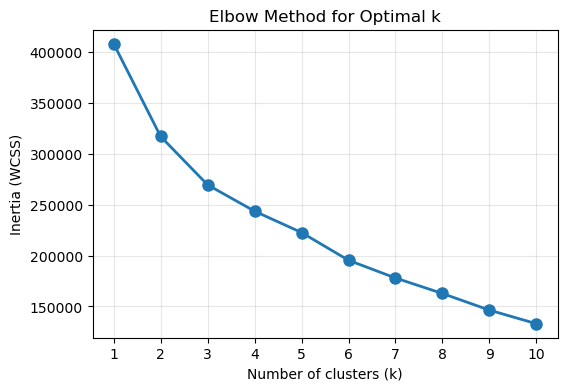

Elbow k: 3


In [8]:
from src.bladder_proteomics.plotting import plot_elbow
inertias = elbow_method(df, k_range=range(1, 11))
plot_elbow(inertias)

elbow_k = calculate_elbow_point(inertias)
print("Elbow k:", elbow_k)

The elbow inertia curve:
- Strong decrease from k=1 → k=2
- Moderate decrease from k=2 → k=3
- After k=3, the curve becomes smoother
- Knee detection says → k = 3

**Elbow conclusion:**
- k=3 is the smallest number of clusters beyond which additional clusters do NOT significantly reduce inertia.
- Data has maybe 2 strong clusters and 1 weaker subcluster inside them

**Overall conclusion:**
- Silhouette says k=2
- Elbow says k=3
- Both agree that there are 2 strong clusters. The 3rd cluster from elbow is likely a weaker subcluster.

In [9]:
from src.bladder_proteomics.clustering import kmeans_cluster, gmm_cluster, agglomerative_cluster

# CLUSTERING
k = 2
labels = kmeans_cluster(df, n_clusters=k)

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'UMAP Plot'}, xlabel='UMAP1', ylabel='UMAP2'>)

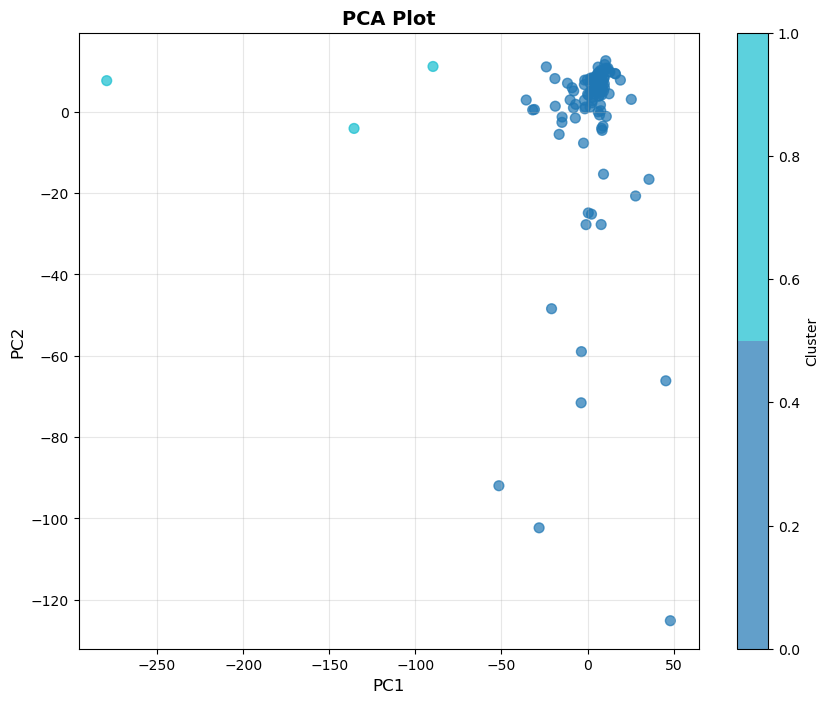

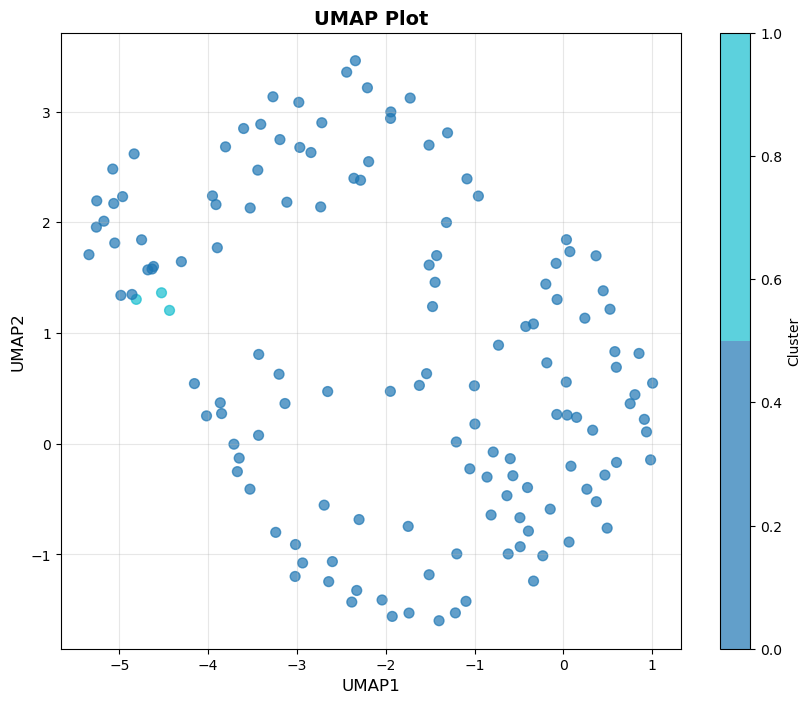

In [10]:
from src.bladder_proteomics.plotting import plot_pca, plot_umap

# Plot PCA/UMAP with labels
plot_pca(pca_df, labels)
plot_umap(umap_df, labels)

PCA explained variance analysis showed that 12 principal components are sufficient to capture ~80% of the dataset’s variability. The 2D PCA and UMAP embeddings suggested two major groups. Silhouette analysis identified k=2 as the optimal cluster count, while the elbow method suggested a secondary knee at k=3. Based on these results, clustering was performed using k=2.

# Level 2 - Feature Discovery

In [11]:
import pandas as pd
from src.bladder_proteomics.feature_selection import anova_select, random_forest_importance
# Use cluster labels from Level 1
# k = 3  # example
# labels = kmeans_cluster(df, n_clusters=k)

# ANOVA (global overview)
anova_selected, anova_mask, (f_scores, pvals) = anova_select(
    df, labels, k="all", return_scores=True
)

# Sort proteins by significance
anova_rank = pd.DataFrame({
    "protein": df.columns,
    "F": f_scores,
    "p": pvals
}).sort_values("p")

# Random Forest
rf_selected, rf_mask, importances = random_forest_importance(
    df, labels, top_k=50
)

# Combine methods
final_features = df.columns[rf_mask]

(<Figure size 1200x1000 with 2 Axes>, <Axes: title={'center': 'Heatmap'}>)

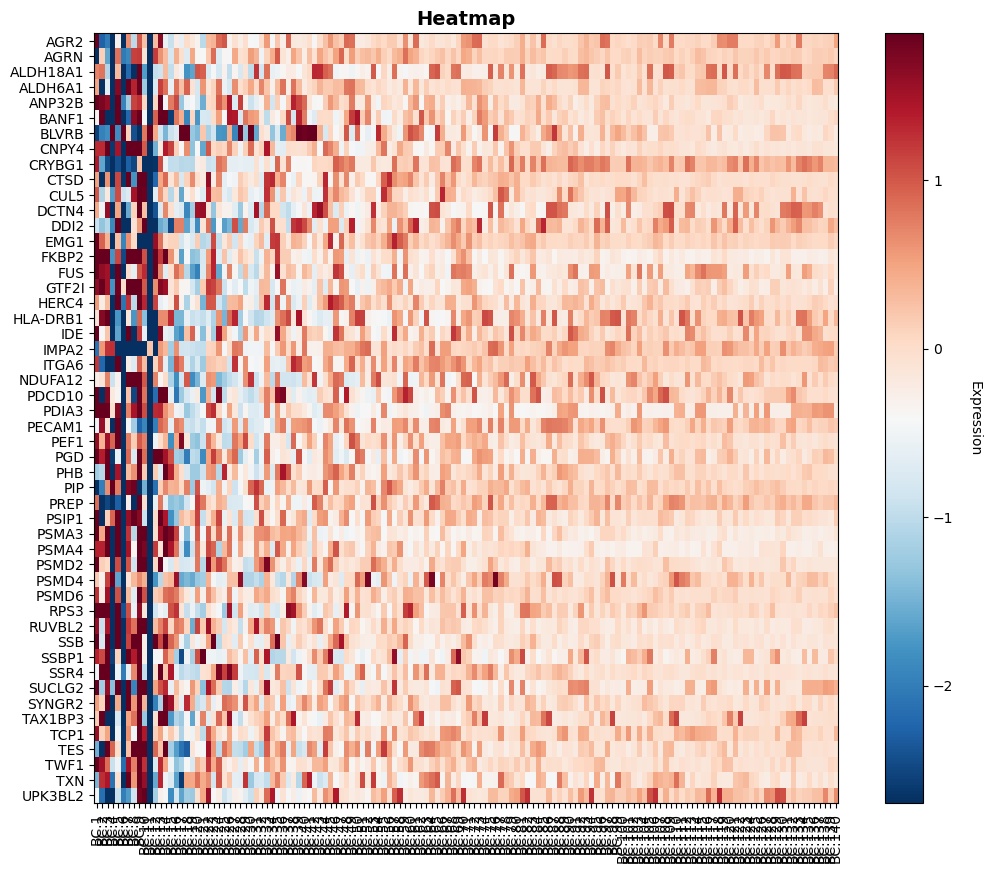

In [12]:
from src.bladder_proteomics.plotting import plot_heatmap
heatmap_df = df[final_features]
plot_heatmap(heatmap_df.T)